# Plotting Multivariate Data in Python (Gene Expression)


I recenty came accross a Kaggle kernel where they used [Andrews' Plots](https://en.wikipedia.org/wiki/Andrews_plot) to visualize the Iris Dataset. Given that heatmap is the to-go method to cluster/visualize gene expression data, I had never heard of this alternative. I wanted to try this technique out on gene expression datasets, even though it is used to detect outliers in a population/sample, I was curious to see how  different stage cancer samples curves would be clustered using this approach.

In [1]:
#The works
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

II will be using a lung adenocarcinoma dataset, with multi-labeled samples (patient gender, cancer stage, smoking habits, etc.) available from [GEO](https://www.ncbi.nlm.nih.gov/sites/GDSbrowser?acc=GDS3257). Details are as follows:

### DataSet Record GDS3257
Cigarette smoking effect on lung adenocarcinoma

Analysis of different tumor stage adenocarcinoma and paired normal lung tissues of current, former and never smokers. To date, tobacco smoking is responsible for over 90% of lung cancers. Results provide insight into the molecular basis of lung carcinogenesis induced by smoking.

**Organism:**	
Homo sapiens

**Platform:**	
GPL96: [HG-U133A] Affymetrix Human Genome U133A Array

**Citation:**
Landi MT, Dracheva T, Rotunno M, Figueroa JD et al. Gene expression signature of cigarette smoking and its role in lung adenocarcinoma development and survival. PLoS One 2008 Feb 20;3(2):e1651. PMID: 18297132

I downloaded the incomplete version of the dataset, so there's no need to strip out gene annotations. However, I did clean the meta-data headers and extracted the group tags. These will be available as a collection of lists. I will place them on a different file for the sake of ａｅｓｔｈｅｔｉｃｓ.

In [2]:
import GDS3257_labels as labels
#tumor, normal, never_smoker, former_smoker, current_smoker, stage_I, stage_II, stage_III, stage_IV, female, male, early_stage, late_stage

Each list contains the tissue sample ID of the cohorts it represents. For example:

In [3]:
labels.tumor[0:3]

['GSM254625', 'GSM254627', 'GSM254629']

In [4]:
#Read in the data
lung = pd.read_csv("GDS3257.txt", delimiter = "\t")

This dataset has 109 columns, but only 107 of those are samples. The other two columns contain the Microarray's Probe Id and the corresponding Gene Ids. Probe Ids are guaranteed to be unique, however, they may (more often than not) map to the same Gene Id. Take this into account when indexing our dataset. 

In [5]:
print "DataFrame dimensions:", lung.shape

DataFrame dimensions: (22283, 109)


In [6]:
lung.iloc[0:3,:5]

,ID_REF,IDENTIFIER,GSM254629,GSM254648,GSM254694
0,1007_s_at,MIR4640,10.98850,10.69190,10.89780
1,1053_at,RFC2,6.82603,6.90960,6.80295
2,117_at,HSPA6,7.77559,7.68374,7.88498


In [7]:
lung.iloc[:,0:2].describe()

,ID_REF,IDENTIFIER
count,22283,22283
unique,22283,14063
top,217039_x_at,--Control
freq,1,58


It seems the dataset has leftover control probe data. According to the dataset's metadata in GEO, _"Data processing Gene expression data were processed and normalized using Bioconductor Affy package, based on the Robust Multichip Average (RMA) method5 for single-channel Affymetrix chips"._ This is consistent with the min and max values observed below. If data weren't normalized ([log2 transform](https://blog.qbaseplus.com/seven-tips-for-bio-statistical-analysis-of-gene-expression-data)), we'd see values up to the thousands of units ([Heteroscedasticity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html)).

In [8]:
print "Dataset Min:", lung.iloc[:,2:].min().min()
print "Dataset Max: ", lung.iloc[:,2:].max().max()

Dataset Min: 3.6701300000000003
Dataset Max:  15.2482


We will remove these rows as part of preprocessing.  Also, let's assign the probe IDs as DataFrame indices.

In [9]:
to_remove = lung.IDENTIFIER.str.contains("--Control")
lung = lung[~to_remove]
lung = lung.set_index("ID_REF")

print "Removed a total of: " , sum(to_remove), " variables"
print "New DataFrame shape: ", lung.shape

Removed a total of:  58  variables
New DataFrame shape:  (22225, 108)


Gene Expression Datasets obtained from GEO usually have samples on the column axis and variables on the row axis.  This might be confusing, as many Machine Learning learning (heh) resources use the opposite convention. I'll transpose the DataFrame to be consistent with the latter, but also because the Andrews' Plot function requires the data that way.

In [10]:
lung = lung.T
lung.head(3)

ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-HSAC07/X00351_3_at,AFFX-HSAC07/X00351_5_at,AFFX-HSAC07/X00351_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at
IDENTIFIER,MIR4640,RFC2,HSPA6,PAX8,GUCA1A,MIR5193,THRA,PTPN21,CCL5,CYP2E1,...,ACTB,ACTB,ACTB,GAPDH,GAPDH,GAPDH,STAT1,STAT1,STAT1,STAT1
GSM254629,10.9885,6.82603,7.77559,9.85506,4.82396,9.1043,6.19335,6.11913,7.7529,4.96849,...,13.5418,12.8276,13.7248,13.2335,12.177,12.503,9.37574,4.61838,8.19851,7.83992
GSM254648,10.6919,6.9096,7.68374,10.1321,4.98489,8.99562,6.31397,6.02121,8.14121,5.13706,...,13.3647,12.4481,13.4898,12.9788,11.3921,11.9168,10.3264,4.7761,8.56324,8.33554


The Gene Id is still present, so let's assign it to a Series and remove it from the DataFrame

In [11]:
identifier = lung.loc["IDENTIFIER"]
lung.drop(inplace=True, labels="IDENTIFIER", axis=0)

The plotting [function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.andrews_curves.html) requires a class column as a parameter. I would like to keep the class vectors outside the DataFrame, but at the moment there seems to be no workaround.  For our first plot, let's split the data into Normal and Cancer (presumably the most different classes).  A small function will allow us to re-label the samples easily in case we want to plot different cohorts (we are).

In [12]:
def set_sample_labels(df, cohort_list, labels):
    for cohort, label in zip(cohort_list, labels):
        df.loc[cohort,"tissue_type"] = label

In [14]:
#Create the tissue type column. This only has to be run once and therefore is out of the function.
lung["tissue_type"] = "Normal"

set_sample_labels(lung, [labels.normal, labels.tumor], ["Normal", "Cancer"])
lung["tissue_type"].value_counts()

Cancer    58
Normal    49
Name: tissue_type, dtype: int64

Andrews' Plot maps each of the variables to a term in a Fourier's finite series. It places greater weight on those variables listed first and less weight on variables listed later. This means the **order in which the variables are presented** affects the visual representation. More on that later.

Let's plot the data as it is!

In [15]:
def set_x_axis_in_radians(ax):
    ax.xaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos:'%g $\pi$'%(x/np.pi)))
    ax.xaxis.set_major_locator(tck.MultipleLocator(base=np.pi/2))

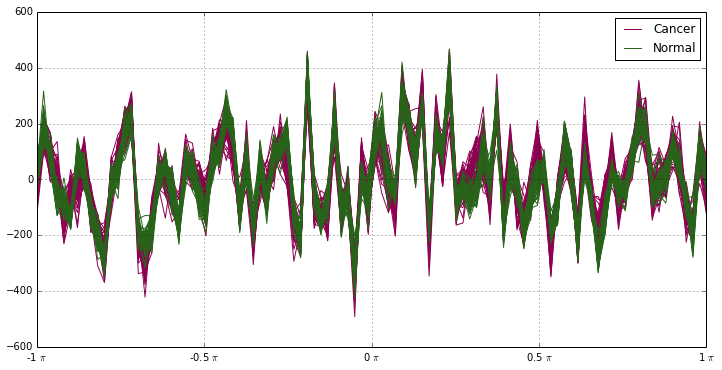

In [16]:
from pandas import plotting
import matplotlib.ticker as tck
%matplotlib inline  

fig, ax = plt.subplots(figsize = (12,6))
set_x_axis_in_radians(ax)
plotting.andrews_curves(lung, "tissue_type", colormap = "PiYG", ax=ax, samples = 100)

Doesn't look too good. The clusters do not seem to be extremely different from each other. There is however a visible perturbation in the cancer plots. Given the technique's behavior we established in the previous step, variables listed later do not have a significant effect on the plot, so it might be possible to visualize better clustering if we ordered the variables according to the fraction of the total variance they explain ([PCA](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)) and used only a subset of them. 

Before that, let's first try plotting known genes supposed to be key in lung carcinogenesis ([biomarkers](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5137804/)), which should be the ones that better differentiate between tumor and normal tissue. 

The documentation for andrew_curves states that data should be preferably be z transformed ([standardization](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)), so let's begin with that.

In [17]:
from sklearn.preprocessing import StandardScaler

lung_standarized = lung
np_scaled = StandardScaler().fit_transform(lung_standarized.drop("tissue_type", axis = 1, inplace=False))
lung_standarized.iloc[:,:-1] = np_scaled

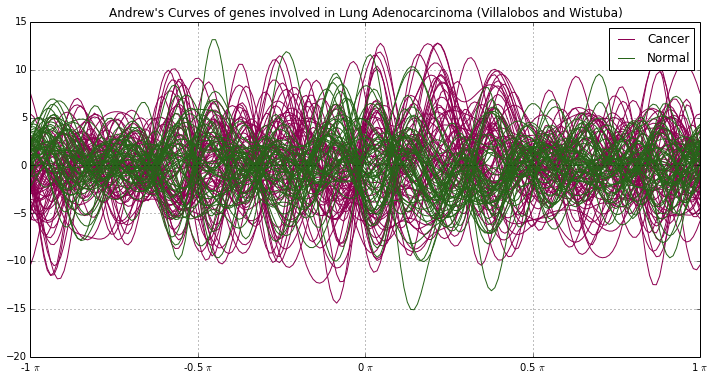

In [18]:
fig, ax = plt.subplots(figsize = (12,6))
set_x_axis_in_radians(ax)
ax.set_title("Andrew's Curves of genes involved in Lung Adenocarcinoma (Villalobos and Wistuba)")

biomarker_genes = ["EGFR","ALK","ROS","KRAS","MET","NTRK1","FGFR","HER2","BRAF","PIK3CA","RET","DDR2","PTEN"]
biomarker = identifier.isin(biomarker_genes)
#Adding the classification column "tissue_type"
biomarker = list(biomarker)
biomarker.append(True)

plotting.andrews_curves(lung_standarized.loc[:,biomarker], "tissue_type", colormap = "PiYG", ax=ax)

Doesn't look very pretty either. Let's take a look at the individual genes.  Remember probes can be mapped to a single gene, like in the case of NRTK1, DDR2 and PIK3CA, where only the linear component is observed (x(t)= x1/sqrt(2)), but also the same gene can be mapped to different probes, and that's why we have plots with sinusoidal components as well (x(t)= x1/sqrt(2) + x2sin(t)+ x3cos(t)+ ...). 

Also, our current dataset/chip doesn't necessarily contain _all_ the genes in the biomarker. This results in only 9/13 possible plots.

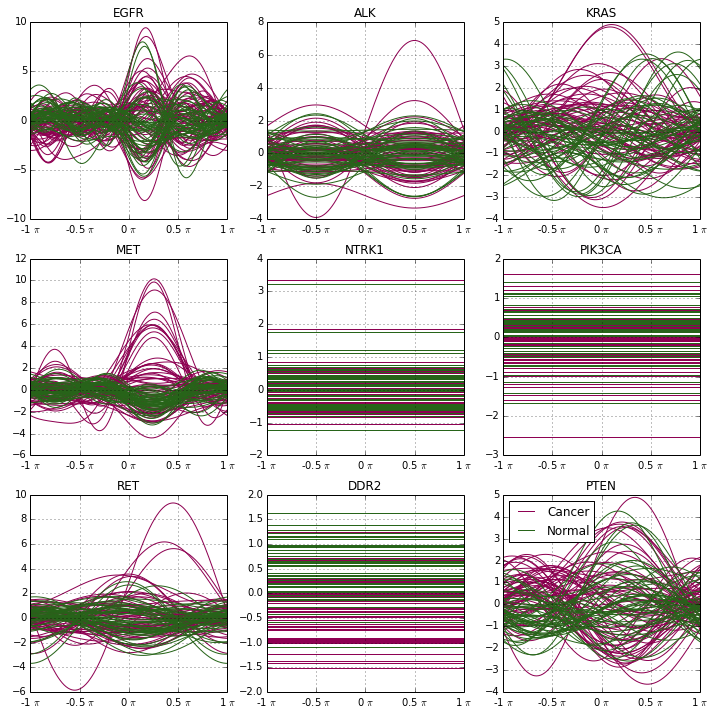

In [20]:
fig = plt.figure(figsize=(12, 12))

#changed the order a little to avoid empty spaces between plots.
biomarker_genes = ["EGFR","ALK","KRAS","MET","NTRK1","PIK3CA","RET","DDR2","PTEN","ROS", "FGFR", "HER2","BRAF"]

for i, gene in enumerate(biomarker_genes):
    if(gene in list(identifier)):
        ax = fig.add_subplot(3, 3, i+1)
        set_x_axis_in_radians(ax)
        ax.set_title(gene)
        biomarker = identifier == gene
        #Adding the classification column "tissue_type"
        biomarker = list(biomarker)
        biomarker.append(True)
        plotting.andrews_curves(lung_standarized.iloc[:,biomarker], "tissue_type", colormap = "PiYG", ax=ax)
        ax.legend().set_visible(False)
plt.legend(loc='upper left')

MET, and to some extent, DDR2 seem to have potential, but in general, the biomarker found in [literature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5137804/) does not seem to be able to properly cluster the samples.  At this point we can find genes that work for this dataset by:

1. Find Differentially Expressed Genes
2. Look up the study this data came from and use their identified genes.

2 would be enough to get a nice plot, but let's go through the trouble of 1 just for the lulz. 

## Differentially Expressed Genes

One technique to identify biomarkers is gene Differential Expression. We can apply a two-tailed t-test to identify which genes are significantly up or downregulated. The current dataset states that normal and tumor samples are paired, so it would be appropriate to apply a paired t-test, however, there is a total of 49 normal and 58 samples, which is inconsistent with the statement.

Let's examine the subclass count. (Subclass labels are available on the Dataset page.)

In [21]:
subclasses = pd.read_csv("sample_sub_classes.csv", header=None, names = ["sample_geo_id", "tissue_type", "smoking_status", "stage", "gender", "stage_lateness", "sample_id"])

In [22]:
subclasses.loc[subclasses.tissue_type=="normal","tissue_type":"stage_lateness"].apply(pd.Series.value_counts)

,tissue_type,smoking_status,stage,gender,stage_lateness
current smoker,NaN,16.0,NaN,NaN,NaN
early stage tumor tissue,NaN,NaN,NaN,NaN,37.0
female,NaN,NaN,NaN,15.0,NaN
former smoker,NaN,18.0,NaN,NaN,NaN
late stage tumor tissue,NaN,NaN,NaN,NaN,12.0
male,NaN,NaN,NaN,34.0,NaN
never smoker,NaN,15.0,NaN,NaN,NaN
normal,49.0,NaN,NaN,NaN,NaN
stage I,NaN,NaN,23.0,NaN,NaN
stage II,NaN,NaN,14.0,NaN,NaN


In [23]:
subclasses.loc[subclasses.tissue_type=="tumor","tissue_type":"stage_lateness"].apply(pd.Series.value_counts)

,tissue_type,smoking_status,stage,gender,stage_lateness
current smoker,NaN,24.0,NaN,NaN,NaN
early stage tumor tissue,NaN,NaN,NaN,NaN,43.0
female,NaN,NaN,NaN,23.0,NaN
former smoker,NaN,18.0,NaN,NaN,NaN
late stage tumor tissue,NaN,NaN,NaN,NaN,15.0
male,NaN,NaN,NaN,35.0,NaN
never smoker,NaN,16.0,NaN,NaN,NaN
stage I,NaN,NaN,22.0,NaN,NaN
stage II,NaN,NaN,21.0,NaN,NaN
stage III,NaN,NaN,12.0,NaN,NaN


This confirms that the samples are indeed not paired. (Stage II and III in Normal vs. in Tumor), and the paired t-test cannot be used. Let's perform an individual t-test.

In [25]:
from scipy.stats import ttest_ind
cancer_subset = lung_standarized.loc[labels.tumor,]
normal_subset = lung_standarized.loc[labels.normal,]
pvalues = [ttest_ind(cancer_subset.iloc[:,i], normal_subset.iloc[:,i]) for i in range(lung_standarized.shape[1]-1)]
pvalues =[result.pvalue for result in pvalues]

Let's use a biomarker made up of the top 10 Differentially Expressed genes. If this were a serious analysis, given that we are performing multiple (thousands) tests, we should calculate the False Discovery Rate and adjust the p-values to reduce the number of Type-I errors. For now, let's use the p-values as a scoring metric only.

In [26]:
scores = pd.Series(list(pvalues))
scores.index = identifier.index

ranked_genes = pd.concat([identifier,scores], axis=1)
ranked_genes.columns = ["ID","score"]
top10 = ranked_genes.sort_values(by=["score"]).iloc[:10,0]
print(list(top10))

['FAM107A', 'CD36', 'GRK5', 'CA4', 'EDNRB', 'CDH5', 'NPR1', 'HIGD1B', 'AGER', 'TEK']


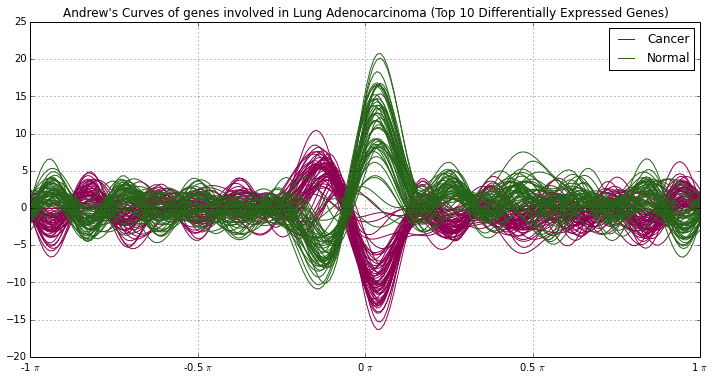

In [27]:
fig, ax = plt.subplots(figsize = (12,6))
set_x_axis_in_radians(ax)
ax.set_title("Andrew's Curves of genes involved in Lung Adenocarcinoma (Top 10 Differentially Expressed Genes)")

biomarker_genes = top10
biomarker = identifier.isin(biomarker_genes)
#Adding the classification column "tissue_type"
biomarker = list(biomarker)
biomarker.append(True)

plotting.andrews_curves(lung_standarized.loc[:,biomarker], "tissue_type", colormap = "PiYG", ax=ax)

**SUCCESS! (?)**

The difference in frequencies and amplitudes is evident in this plot. Let's take a look at the individual genes.

In [42]:
def plot_individual_genes(biomarker_genes, dim, df= lung_standarized, cm = "PiYG"):
    for i, gene in enumerate(biomarker_genes):
        if(gene in list(identifier)):
            ax = fig.add_subplot(dim[0], dim[1], i+1)
            set_x_axis_in_radians(ax)
            ax.set_title(gene)
            biomarker = identifier == gene

            #Adding the classification column "tissue_type"
            biomarker = list(biomarker)
            biomarker.append(True)

            plotting.andrews_curves(df.iloc[:,biomarker], "tissue_type", colormap = cm , ax=ax)
            ax.legend().set_visible(False)
    plt.legend(loc='best')
    plt.tight_layout()

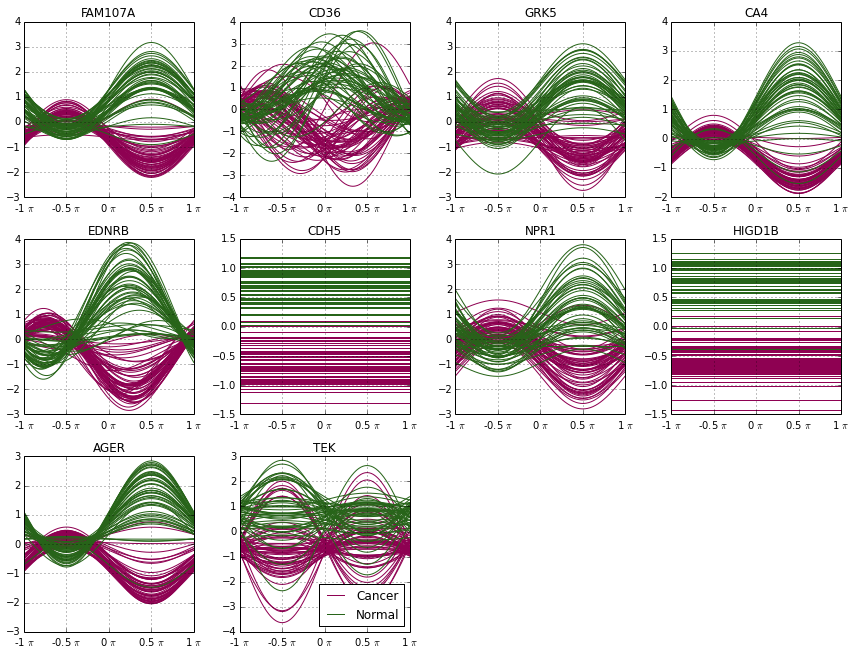

In [43]:
fig = plt.figure(figsize=(12, 12))
plot_individual_genes(top10, [4,4])

I love how the curves from each cohort are nicely separted!!  Let's oberve the results we get if we use the candidate genes from the original study.

In [44]:
#Genes from the original study. some of them are significant only for some classes.
original_genes = ["NEK2","TTK","PRC1", "CENPF", "BIRC5", "MAD2L1","ASPM","CDC2","CKS1B","CKS2","RACGAP1","CDC2","KIF15","BUB1","TPX2","CCNA2","MKI67","KPNA2","KIF2C","CKAP2","PLK4","MACF1","CDKN1A","DUSP6"]

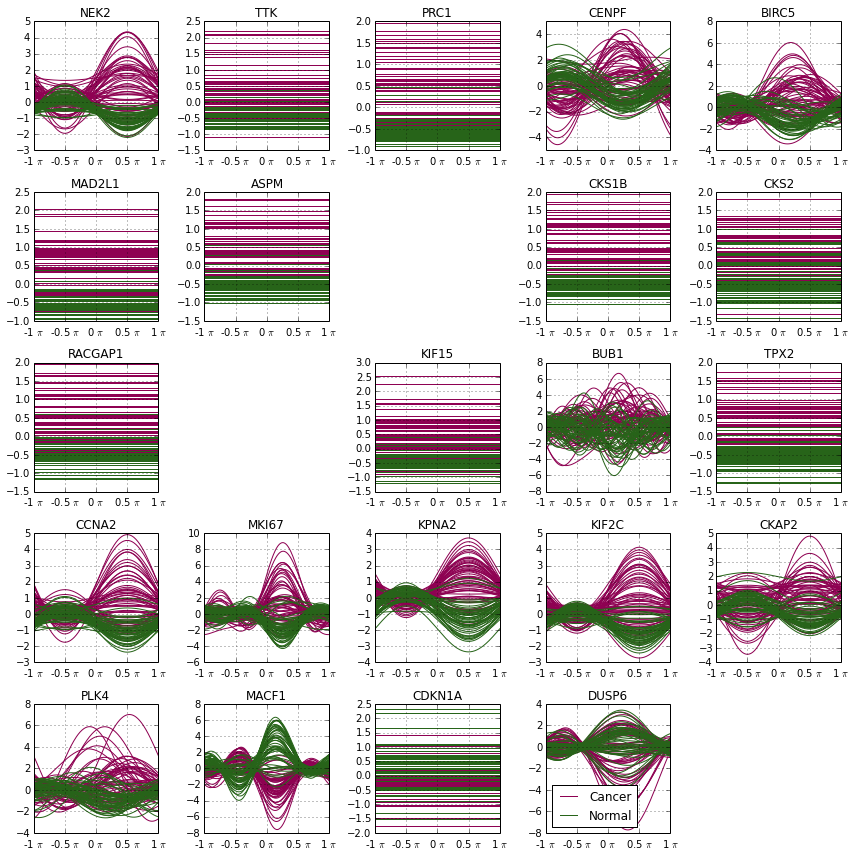

In [45]:
fig = plt.figure(figsize=(12, 12))

plot_individual_genes(original_genes, [5,5])

These genes also provide a nice way to visualize the two different cohorts, however, there are some like CDKN1A and DUSP6 that have concerning overlaps. This is actualy expected, as in the original [paper](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0001651.t002), both of these genes are significant when differentiating smokers from never smokers, and not tumor and normal samples. 

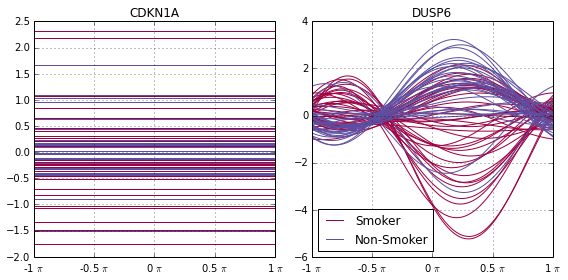

In [53]:
set_sample_labels(lung_standarized, [labels.current_smoker, labels.never_smoker], ["Smoker", "Non-Smoker"])
fig = plt.figure(figsize=(8, 4))
plot_individual_genes(["CDKN1A","DUSP6"], [1,2], df=lung_standarized.loc[labels.current_smoker + labels.never_smoker,], cm = "Spectral")

Hmm, DUSP6 indeed seems to improve at visualizing Smoker Vs Non-Smokers, but CDKN1A doesn't.

--------Draft---------------


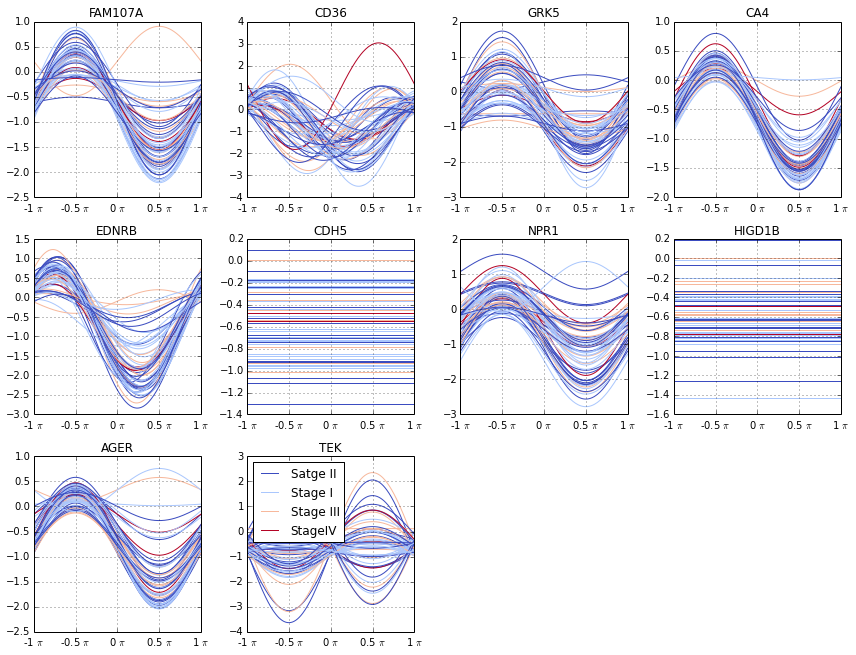

In [56]:
set_sample_labels(lung_standarized, [labels.stage_I, labels.stage_II, labels.stage_III, labels.stage_IV], ["Stage I", "Satge II", "Stage III", "StageIV"])
fig = plt.figure(figsize=(12, 12))
plot_individual_genes(top10, [4,4], df=lung_standarized.loc[labels.tumor,], cm = "coolwarm")

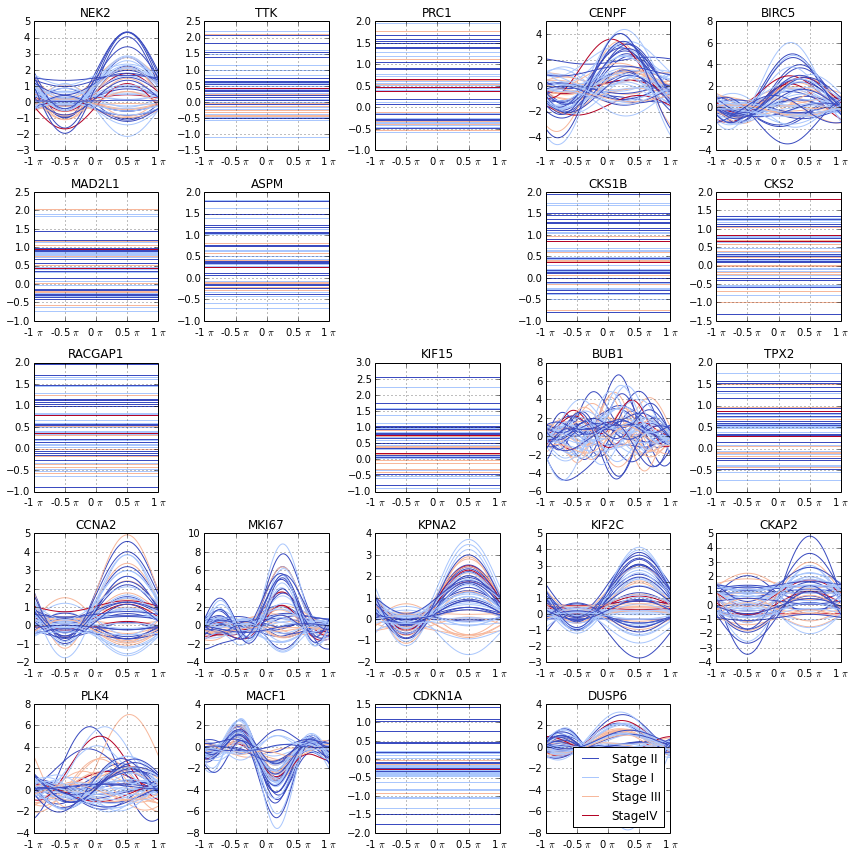

In [57]:
set_sample_labels(lung_standarized, [labels.stage_I, labels.stage_II, labels.stage_III, labels.stage_IV], ["Stage I", "Satge II", "Stage III", "StageIV"])
fig = plt.figure(figsize=(12, 12))
plot_individual_genes(original_genes, [5,5], df=lung_standarized.loc[labels.tumor,], cm = "coolwarm")

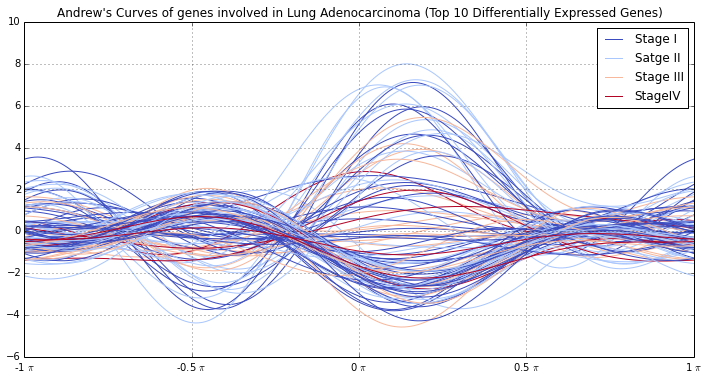

In [76]:
fig, ax = plt.subplots(figsize = (12,6))
set_x_axis_in_radians(ax)
ax.set_title("Andrew's Curves of genes involved in Lung Adenocarcinoma (Top 10 Differentially Expressed Genes)")

biomarker_genes = ["NEK2", "KIF15", "KNPA2", "KIF2C"]
biomarker = identifier.isin(biomarker_genes)
#Adding the classification column "tissue_type"
biomarker = list(biomarker)
biomarker.append(True)

plotting.andrews_curves(lung_standarized.loc[:,biomarker], "tissue_type", colormap = "coolwarm", ax=ax)

2DO: Perform an ANOVA to get DE genes among groups and visualize that.